In [ ]:
import sys
sys.path.append('./mytorch')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mytorch import Tensor
from mytorch.model import Model
from mytorch.layer import Linear
from mytorch.activation import relu, softmax
from mytorch.loss import CategoricalCrossEntropy
from mytorch.optimizer import Adam



def load_diabetes_csv(path="diabetes.csv"):
    df = pd.read_csv(path)

    zero_bad = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
    df[zero_bad] = df[zero_bad].replace(0, np.nan)
    df[zero_bad] = df[zero_bad].fillna(df[zero_bad].median())

    X = df.drop("Outcome", axis=1).values.astype(np.float64)
    y = df["Outcome"].values.astype(int)

    # normalize
    mean = X.mean(axis=0)
    std = X.std(axis=0) + 1e-8
    X = (X - mean) / std

    return X, y

class DiabetesMLP(Model):
    def __init__(self):
        super().__init__()
        self.l1 = Linear(8, 32, need_bias=True, mode="he")
        self.l2 = Linear(32, 16, need_bias=True, mode="he")
        self.out = Linear(16, 2, need_bias=True, mode="xavier")

    def forward(self, x: Tensor):
        x = relu(self.l1(x))
        x = relu(self.l2(x))
        return self.out(x)   # logits (softmax later)

    def parameters(self):
        return [self.l1, self.l2, self.out]



def evaluate_model(model, X, y):
    """Evaluate model on given data and return accuracy"""
    X_t = Tensor(X)
    probs = softmax(model(X_t)).data
    y_pred = np.argmax(probs, axis=1)
    acc = np.mean(y_pred == y)
    return acc

def train(model, X_train, y_train, X_test, y_test, lr=0.001, epochs=200, batch=32):

    optimizer = Adam(model.parameters(), learning_rate=lr)

    N = len(X_train)
    loss_list = []
    train_acc_list = []
    test_acc_list = []

    print("------------------------------------------------")
    print("Training started...")
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    print(f"Batch size: {batch}")
    print("------------------------------------------------\n")

    for epoch in range(1, epochs + 1):

        perm = np.random.permutation(N)
        Xp, yp = X_train[perm], y_train[perm]

        total_loss = 0
        correct = 0
        batch_count = 0

        for i in range(0, N, batch):
            xb = Xp[i:i+batch]
            yb = yp[i:i+batch]

            xb_t = Tensor(xb, requires_grad=True)
            yb_t = Tensor(yb, requires_grad=False)

            logits = model(xb_t)
            probs = softmax(logits)

            loss = CategoricalCrossEntropy(probs, yb_t)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += float(loss.data)
            batch_count += 1

            pred_cls = np.argmax(probs.data, axis=1)
            correct += np.sum(pred_cls == yb)

        epoch_train_acc = correct / N
        loss_list.append(total_loss / batch_count)
        train_acc_list.append(epoch_train_acc)

        # Evaluate on test set every 10 epochs
        if epoch % 10 == 0 or epoch == 1:
            epoch_test_acc = evaluate_model(model, X_test, y_test)
            test_acc_list.append((epoch, epoch_test_acc))
            print(f"Epoch {epoch:3d}/{epochs} | Loss: {total_loss/batch_count:.4f} | "
                  f"Train Acc: {epoch_train_acc:.4f} | Test Acc: {epoch_test_acc:.4f}")
        else:
            print(f"Epoch {epoch:3d}/{epochs} | Loss: {total_loss/batch_count:.4f} | "
                  f"Train Acc: {epoch_train_acc:.4f}")

    print("\nTraining finished.")
    print("------------------------------------------------\n")

    return model, loss_list, train_acc_list, test_acc_list


def confusion(y_true, y_pred):
    cm = np.zeros((2, 2), dtype=int)
    for yt, yp in zip(y_true, y_pred):
        cm[yt, yp] += 1
    return cm


def final_evaluate(model, X, y):
    X_t = Tensor(X)
    probs = softmax(model(X_t)).data
    y_pred = np.argmax(probs, axis=1)
    acc = np.mean(y_pred == y)

    print("=" * 50)
    print("FINAL EVALUATION RESULTS")
    print("=" * 50)
    print(f"Final Test Accuracy: {acc:.4f} ({acc*100:.2f}%)")
    
    # Check requirements
    if acc >= 0.60:
        print("✅ SUCCESS: Test accuracy >= 60% requirement achieved!")
    else:
        print("❌ Test accuracy requirement not met")
    
    print("\nConfusion Matrix:")
    cm = confusion(y, y_pred)
    print(cm)
    print(f"\nTrue Positives: {cm[1,1]}")
    print(f"True Negatives: {cm[0,0]}")
    print(f"False Positives: {cm[0,1]}")
    print(f"False Negatives: {cm[1,0]}")
    
    return acc, y_pred



def plot_training_results(loss_list, train_acc_list, test_acc_list, final_test_acc):
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Loss
    plt.subplot(1, 3, 1)
    plt.plot(loss_list, 'b-', linewidth=2)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Train vs Test Accuracy
    plt.subplot(1, 3, 2)
    epochs = range(1, len(train_acc_list) + 1)
    plt.plot(epochs, train_acc_list, 'b-', label='Train Accuracy', linewidth=2)
    
    # Plot test accuracy points
    test_epochs = [item[0] for item in test_acc_list]
    test_accs = [item[1] for item in test_acc_list]
    plt.plot(test_epochs, test_accs, 'ro-', label='Test Accuracy', linewidth=2, markersize=4)
    
    # Add target line
    plt.axhline(y=0.60, color='r', linestyle='--', alpha=0.7, label='Target 60%')
    plt.axhline(y=final_test_acc, color='g', linestyle='--', alpha=0.7, label=f'Final Test: {final_test_acc:.3f}')
    
    plt.title('Train vs Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Final comparison
    plt.subplot(1, 3, 3)
    categories = ['Train', 'Test']
    accuracies = [train_acc_list[-1], final_test_acc]
    colors = ['blue', 'red']
    
    bars = plt.bar(categories, accuracies, color=colors, alpha=0.7)
    plt.axhline(y=0.60, color='r', linestyle='--', alpha=0.7, label='Target 60%')
    plt.title('Final Accuracy Comparison')
    plt.ylabel('Accuracy')
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom')
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def main():
    # Load data
    X, y = load_diabetes_csv("diabetes.csv")

    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    print("Dataset Info:")
    print(f"Total samples: {len(X)}")
    print(f"Train size: {len(X_train)}")
    print(f"Test size: {len(X_test)}")
    print(f"Positive cases (diabetes): {np.sum(y)}")
    print(f"Negative cases (no diabetes): {len(y) - np.sum(y)}")
    print("------------------------------------------------\n")

    # Initialize model
    model = DiabetesMLP()

    # Train with test monitoring
    model, loss_log, train_acc_log, test_acc_log = train(
        model,
        X_train, y_train,
        X_test, y_test,
        lr=0.001,
        epochs=200,
        batch=32
    )

    # Final evaluation
    final_test_acc, y_pred = final_evaluate(model, X_test, y_test)

    # Plot results
    plot_training_results(loss_log, train_acc_log, test_acc_log, final_test_acc)

    # Print summary
    print("\n" + "=" * 50)
    print("TRAINING SUMMARY")
    print("=" * 50)
    print(f"Final Train Accuracy: {train_acc_log[-1]:.4f} ({train_acc_log[-1]*100:.2f}%)")
    print(f"Final Test Accuracy: {final_test_acc:.4f} ({final_test_acc*100:.2f}%)")
    
    if train_acc_log[-1] >= 0.70 and final_test_acc >= 0.60:
        print("🎉 EXCELLENT! All requirements achieved!")
        print("   ✓ Train Accuracy >= 70%")
        print("   ✓ Test Accuracy >= 60%")
    elif final_test_acc >= 0.60:
        print("✅ GOOD! Test requirement achieved!")
        print("   ✓ Test Accuracy >= 60%")
    else:
        print("❌ Requirements not fully met")
        print("   Need to improve model performance")


if __name__ == "__main__":
    main()

In [35]:
#don't change this cell
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [36]:
#TODO: Load the dataset
FILE_PATH = "diabetes.csv"

In [48]:
#don't change this cell
df = pd.read_csv(FILE_PATH, header=0)

# rename outcome to diagnosis and convert to binary (already 0/1)
df = df.rename(columns={"Outcome": "Diagnosis"})

df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Diagnosis
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [49]:
import numpy as np

# 1. جایگزینی صفرهای نامعتبر با میانگین (Imputation)
cols_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

for col in cols_with_zeros:
    median_by_class = df.groupby("Diagnosis")[col].median()
    df.loc[df["Diagnosis"] == 0, col] = df.loc[df["Diagnosis"] == 0, col].fillna(median_by_class[0])
    df.loc[df["Diagnosis"] == 1, col] = df.loc[df["Diagnosis"] == 1, col].fillna(median_by_class[1])

X = df.drop("Diagnosis", axis=1).values
y = df["Diagnosis"].values

# 2. استانداردسازی (StandardScaler)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# سپس تبدیل به تنسور
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [50]:
#TODO
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [51]:
#TODO
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        # لایه ورودی به لایه مخفی اول (تعداد نورون‌ها را برای یادگیری بهتر ۳۲ در نظر گرفتیم)
        self.fc1 = nn.Linear(input_size, 64)
        # لایه‌های میانی
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        # لایه خروجی (۱ نورون برای کلاس‌بندی باینری)
        self.output = nn.Linear(16, 1)
        
        # توابع فعال‌سازی طبق داکیومن
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.output(x))
        return x

In [57]:
#TODO
input_size = X_train.shape[1]  # = 8  ## تعداد ویژگی‌های دیتاست دیابت (Pregnancies, Glucose, ..., Age)
model = MLP(input_size).to(device)

# چون خروجی Sigmoid داریم و مسئله باینری است، از BCELoss استفاده می‌کنیم
criterion = nn.BCELoss() 

# استفاده از Adam طبق داکیومنت
optimizer = optim.Adam(model.parameters(), lr=0.001) 

NUM_EPOCHS = 200 # تعداد دورهای آموزش برای رسیدن به همگرایی مناسب

In [58]:
train_accuracy_list= []
test_accuracy_list= []

#TODO
for epoch in range(NUM_EPOCHS):
    model.train()
    total = 0
    corrects = 0
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # جمع‌آوری Loss (میانگین بچ را ضربدر سایز نکنیم چون بعدا تقسیم بر تعداد بچ می‌شود)
        # اما برای نمایش دقیق‌تر معمولا loss.item() کافیست اگر تقسیم بر len(loader) شود.
        running_loss += loss.item()
        
        # محاسبه دقت
        total += labels.size(0)
        predicted = (outputs > 0.5).float() # ترشولد ۰.۵ برای خروجی سیگمویید
        corrects += (predicted == labels).sum().item()

    accuracy = corrects / total
    train_accuracy_list.append(accuracy)
    
    # چاپ وضعیت هر ۱۰ ایپاک (برای شلوغ نشدن خروجی) یا هر ایپاک
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {(running_loss / len(train_loader)):.4f}, Accuracy= {accuracy:.4f}")

    # ارزیابی روی داده‌های تست
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_accuracy = correct / total
    test_accuracy_list.append(test_accuracy)
    
    if (epoch+1) % 10 == 0:
        print(f"Test Accuracy: {test_accuracy:.4f}", end="\n\n")

# چاپ نهایی
print(f"Final Train Accuracy: {train_accuracy_list[-1]:.4f}")
print(f"Final Test Accuracy: {test_accuracy_list[-1]:.4f}")

Epoch 10/200, Loss: 0.3745, Accuracy= 0.8225
Test Accuracy: 0.8247

Epoch 20/200, Loss: 0.2799, Accuracy= 0.8876
Test Accuracy: 0.8506

Epoch 30/200, Loss: 0.2348, Accuracy= 0.9104
Test Accuracy: 0.8506

Epoch 40/200, Loss: 0.2062, Accuracy= 0.9218
Test Accuracy: 0.8312

Epoch 50/200, Loss: 0.1708, Accuracy= 0.9283
Test Accuracy: 0.8442

Epoch 60/200, Loss: 0.1491, Accuracy= 0.9430
Test Accuracy: 0.8377

Epoch 70/200, Loss: 0.1094, Accuracy= 0.9642
Test Accuracy: 0.8506

Epoch 80/200, Loss: 0.0796, Accuracy= 0.9788
Test Accuracy: 0.8312

Epoch 90/200, Loss: 0.0607, Accuracy= 0.9886
Test Accuracy: 0.8312

Epoch 100/200, Loss: 0.0398, Accuracy= 0.9935
Test Accuracy: 0.8377

Epoch 110/200, Loss: 0.0287, Accuracy= 0.9984
Test Accuracy: 0.8312

Epoch 120/200, Loss: 0.0210, Accuracy= 0.9984
Test Accuracy: 0.8247

Epoch 130/200, Loss: 0.0131, Accuracy= 0.9984
Test Accuracy: 0.8312

Epoch 140/200, Loss: 0.0105, Accuracy= 1.0000
Test Accuracy: 0.8247

Epoch 150/200, Loss: 0.0075, Accuracy= 1.00

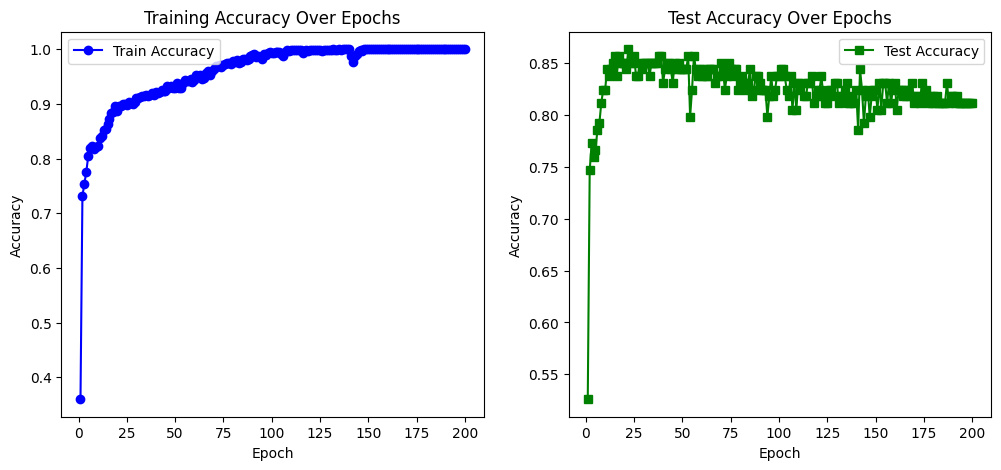

In [59]:
# don't change this cell
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS+1), train_accuracy_list, marker='o', linestyle='-', color='b', label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS+1), test_accuracy_list, marker='s', linestyle='-', color='g', label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Over Epochs")
plt.legend()

plt.show()